In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
import copy
from functools import reduce

%matplotlib inline

In [2]:
PURPLE = '\033[95m'
CYAN = '\033[96m'
DARKCYAN = '\033[36m'
BLUE = '\033[94m'
GREEN = '\033[92m'
YELLOW = '\033[93m'
RED = '\033[91m'
BOLD = '\033[1m'
VANILLA = '\033[0m'
UNDERLINE = '\033[4m'
END = '\033[0m'

In [132]:
df = pd.read_csv('hw3.csv')

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2667 entries, 0 to 2666
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ts         2667 non-null   object 
 1   open       2667 non-null   float64
 2   high       2163 non-null   float64
 3   low        2378 non-null   float64
 4   close      2531 non-null   float64
 5   volume     2667 non-null   float64
 6   volumeUSD  0 non-null      float64
 7   token      2667 non-null   object 
 8   chain      2667 non-null   object 
dtypes: float64(6), object(3)
memory usage: 187.6+ KB


we can see that we have 2667 total entries but high, low and close have a bunch of nulls. Let's have a more thorough look :

In [134]:
for column in df.columns:
    print(BOLD,str(column)+VANILLA,": ")
    print('null values: '+str(pd.isnull(df[column]).any()))
    if df[column].dtype == float:
        print('nan values: '+str(np.isnan(df[column]).any()))
        print('infinite values: '+str(np.isinf(df[column]).any()))

 ts : 
null values: False
 open : 
null values: False
nan values: False
infinite values: False
 high : 
null values: True
nan values: True
infinite values: False
 low : 
null values: True
nan values: True
infinite values: False
 close : 
null values: True
nan values: True
infinite values: False
 volume : 
null values: False
nan values: False
infinite values: False
 volumeUSD : 
null values: True
nan values: True
infinite values: False
 token : 
null values: False
 chain : 
null values: False


- nan values and null values in higher price, lower price, close price and volume USD
- no infinite values

We also immediately saw that the dates weren't sorted. We will sort it out :

In [135]:
df = df.sort_values('ts')
df.ts = pd.to_datetime(df.ts)
df.index = df.ts
del df['ts']

In [136]:
pd.isnull(df).sum()/(df.count()+pd.isnull(df).sum())*100

open           0.000000
high          18.897638
low           10.836145
close          5.099363
volume         0.000000
volumeUSD    100.000000
token          0.000000
chain          0.000000
dtype: float64

- 19% of missing values in higher price
- 11% of missing values in lower price
- 5% of missing values in close price
- 100% of missing values in volume USD (aim of the exercise)

Let's check for any bad formatted chain on token entry

In [137]:
print('chain entries: ')
print(df['chain'].value_counts())
print('Token entries: ')
print(df['token'].value_counts())

chain entries: 
ETH     1663
BTC      337
SOL      334
USDT     333
Name: chain, dtype: int64
Token entries: 
BTC                                   323
COMP                                  322
CRV                                   318
SOL                                   318
USDT                                  314
UNI                                   312
AAVE                                  312
ETH                                   298
<span name="tokenName">UNI</span>      30
<span name="tokenName">ETH</span>      28
<span name="tokenName">USDT</span>     19
<span name="tokenName">CRV</span>      17
<span name="tokenName">AAVE</span>     16
<span name="tokenName">SOL</span>      16
<span name="tokenName">BTC</span>      14
<span name="tokenName">COMP</span>     10
Name: token, dtype: int64


we thus have some badly formatted token names (maybe we pulled from html). Let's solve this:

In [138]:
for token in ['BTC','COMP','CRV','SOL','USDT','UNI','AAVE','ETH']:
    df = df.replace({'<span name="tokenName">'+token+'</span>': token})
df['token'].value_counts()

UNI     342
BTC     337
CRV     335
SOL     334
USDT    333
COMP    332
AAVE    328
ETH     326
Name: token, dtype: int64

Issue solved. Let's now check for any duplicated row:

In [139]:
df.duplicated().sum()

307

Let's get rid of them:

In [140]:
df = df.drop_duplicates() 

We observed that one chain can be associated to different tokens, thus displaying different prices at a same hour

In [161]:
for chain in df.chain.unique():
    print(BOLD,'Associated with'+BOLD,str(chain))
    print(tuple(df[df.chain == chain]['token'].unique()))

 Associated with SOL
('SOL',)
 Associated with ETH
('COMP', 'AAVE', 'UNI', 'ETH', 'CRV')
 Associated with BTC
('BTC',)
 Associated with USDT
('USDT',)


The only issue is with ETH. From a check on cryptowat.ch, it appears that COMP, AAVE, UNI and CRV has nothing to do with ETH. 

In [168]:
df = df[df.token.isin(['SOL','ETH','BTC','USDT'])]

----

##### plot values that we need

In [169]:
df.chain.unique()

array(['SOL', 'BTC', 'ETH', 'USDT'], dtype=object)

In [170]:
import math

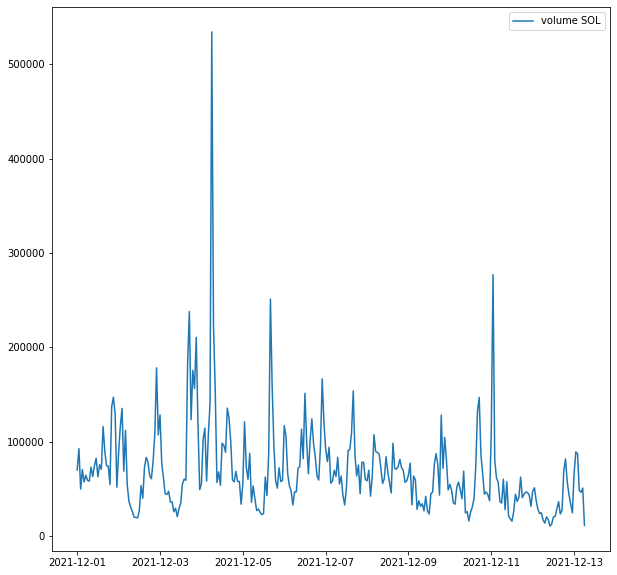

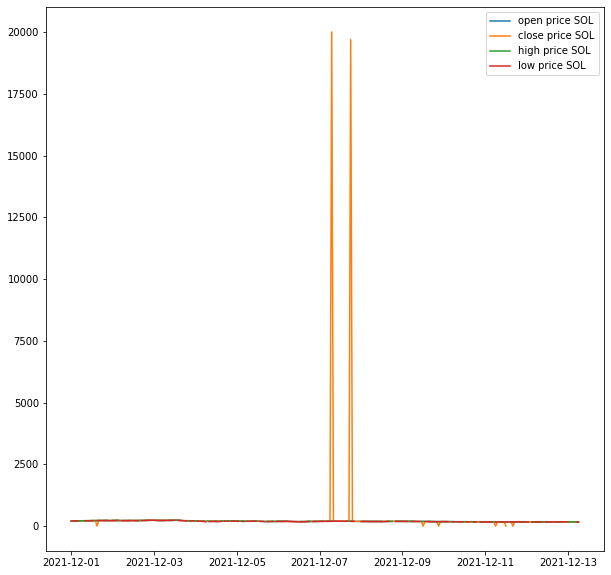

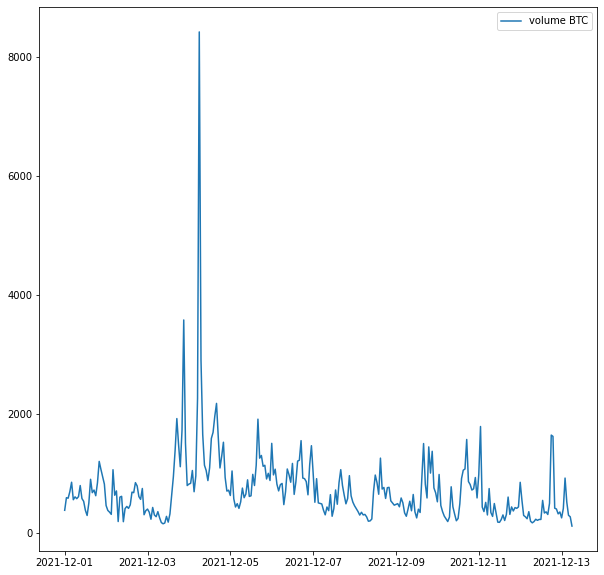

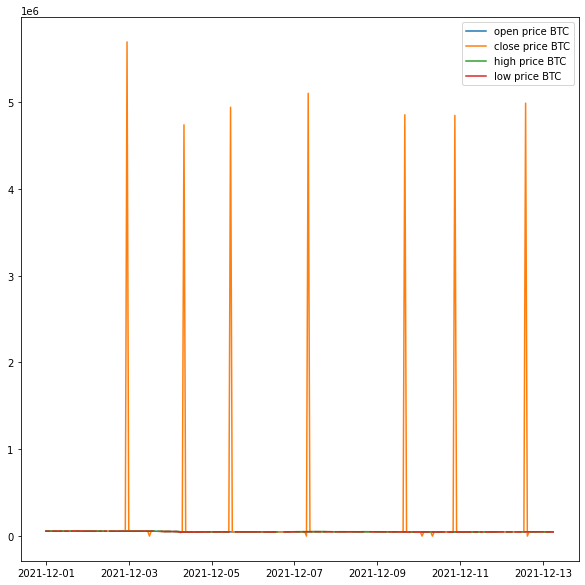

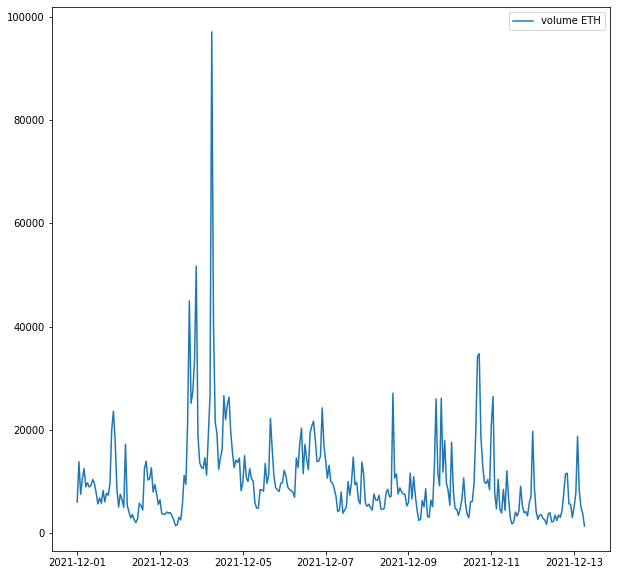

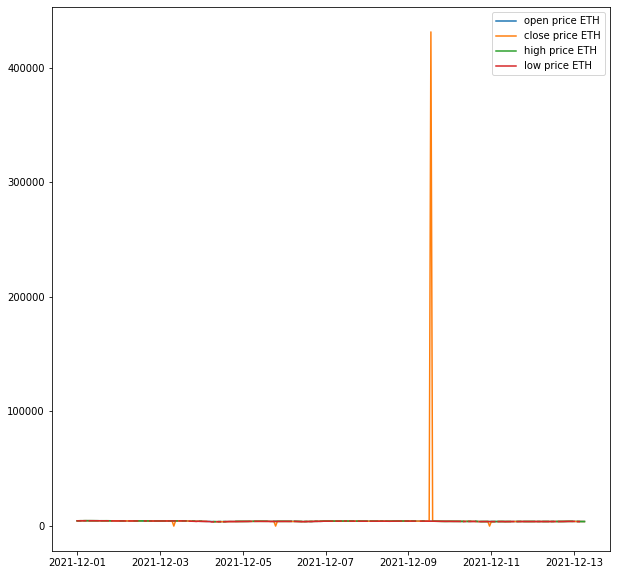

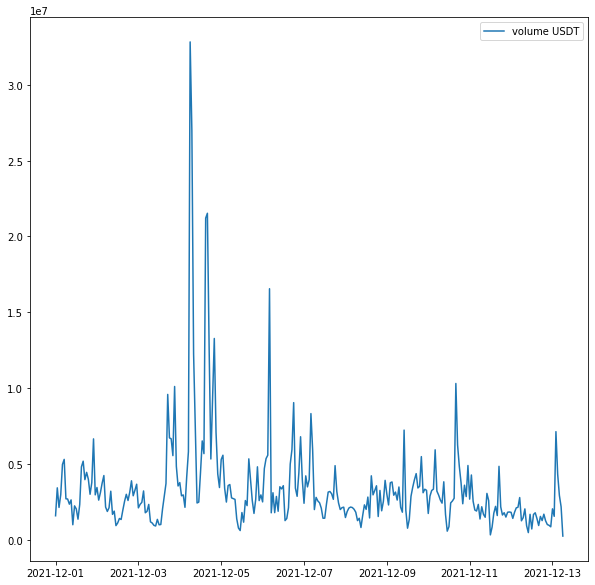

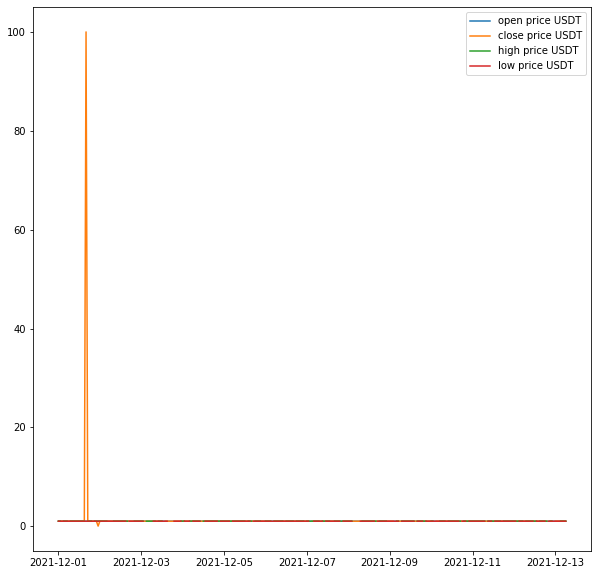

In [171]:
for chain in df.chain.unique():
    plt.figure(figsize =(10,10))
    df_chain = df[df.chain==chain]
    plt.plot(df_chain['volume'], label = 'volume '+str(chain))
    plt.legend()
    plt.show()
    plt.figure(figsize =(10,10))
    plt.plot(df_chain['open'], label = 'open price '+str(chain))
    plt.plot(df_chain['close'], label = 'close price '+str(chain))
    plt.plot(df_chain['high'], label = 'high price '+str(chain))
    plt.plot(df_chain['low'], label = 'low price '+str(chain))
    plt.legend()
    plt.show()

Some close price values are missing, others look like outliers. The volumes look relevant.

Let's use the plan of attack used in Lecture 3. Duplicated rows have already been removed, and tokens have been changed, even though we could have used the chain. Let's use the heuristic for missing close prices as verage of high + low of the day:

In [172]:
df.loc[df['close'].isnull(), 'close'] = 0.5 * (df.loc[df['close'].isnull(), 'high'] + df.loc[df['close'].isnull(), 'low'])

C:\Users\campo\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


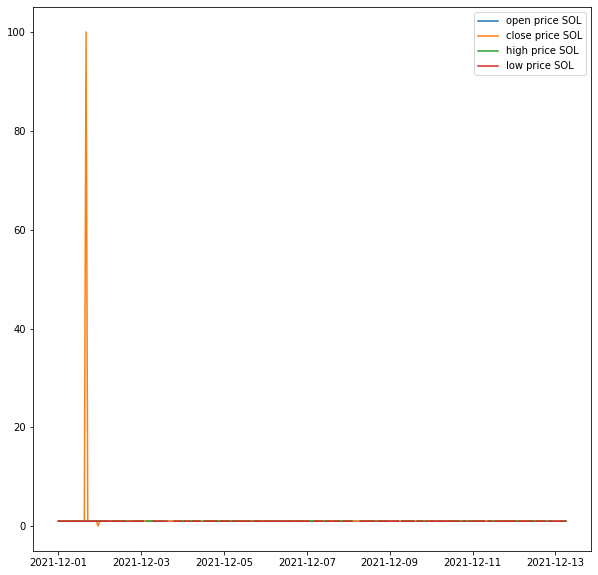

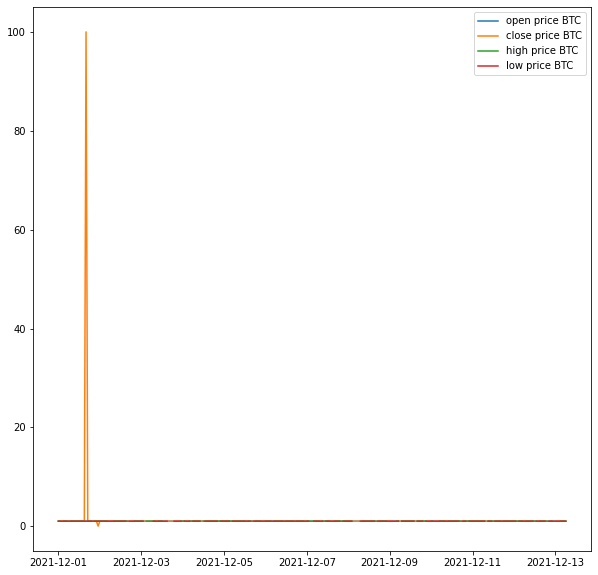

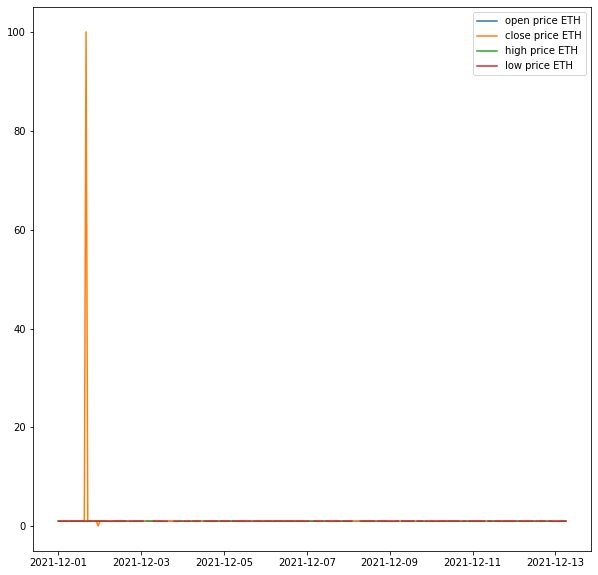

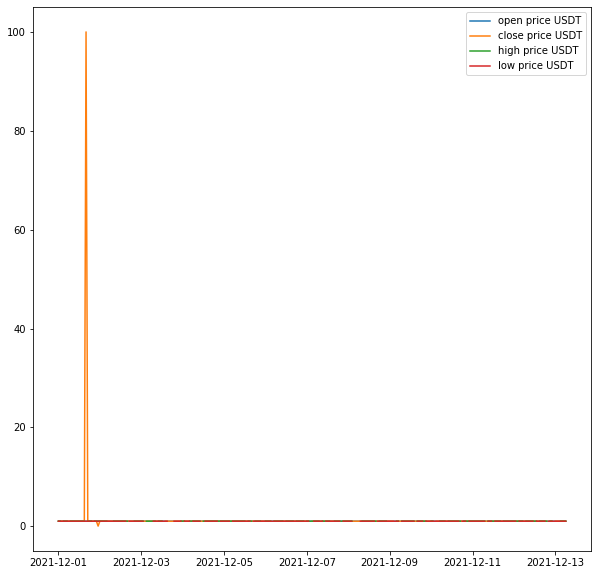

In [173]:
for chain in df.chain.unique():
    plt.figure(figsize =(10,10))
    plt.plot(df_chain['open'], label = 'open price '+str(chain))
    plt.plot(df_chain['close'], label = 'close price '+str(chain))
    plt.plot(df_chain['high'], label = 'high price '+str(chain))
    plt.plot(df_chain['low'], label = 'low price '+str(chain))
    plt.legend()
    plt.show()

Let's try with the heuristic used in Lecture 3, that is to say a value will be considered as an outlier as soon as the close price is more than twice higher than the open price. Following the same reasoning, let's consider than when the close price is less than twice lower than the open price, it also is an outlier.

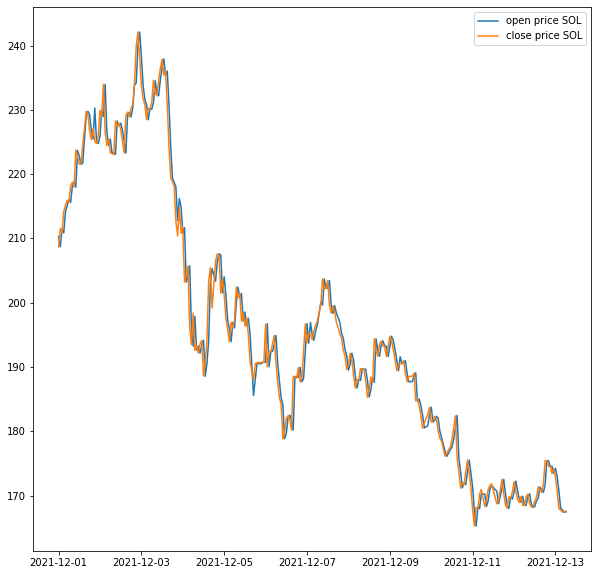

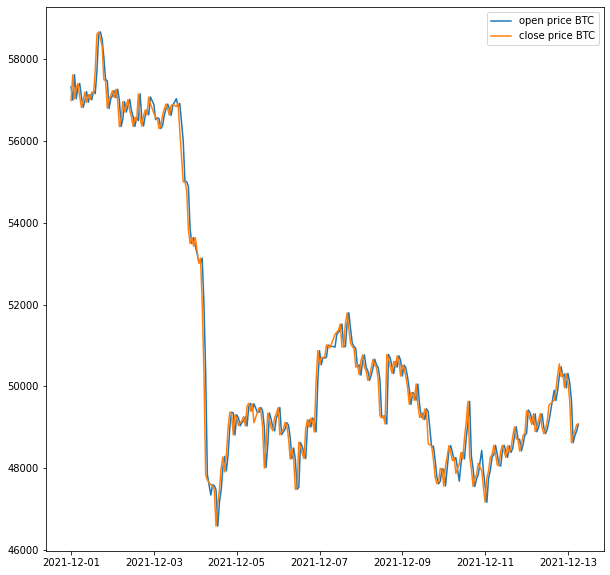

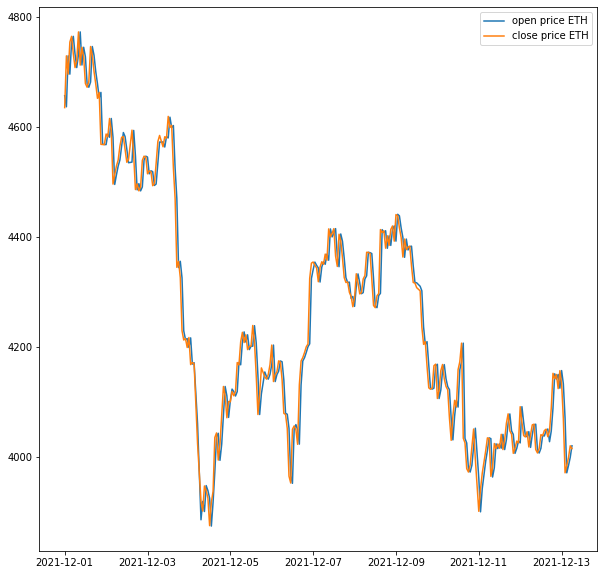

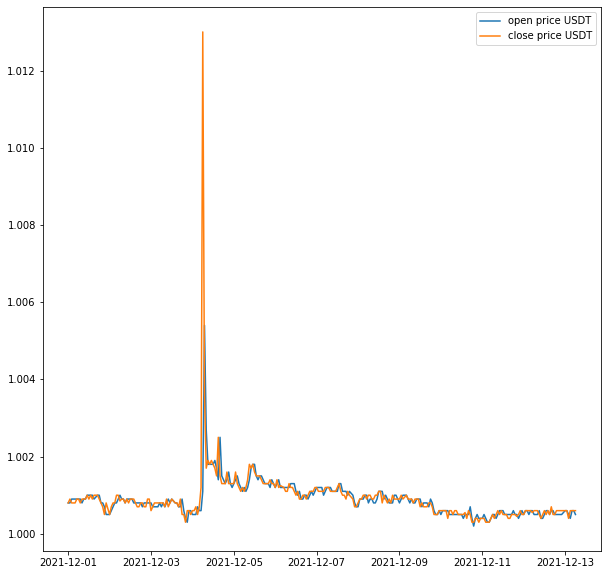

In [174]:
for chain in df.chain.unique():
    df_chain = df[df.chain==chain]
    df_chain = df_chain.loc[df_chain.close / df_chain.open < 2]
    df_chain = df_chain.loc[df_chain.close / df_chain.open > 0.5]
    plt.figure(figsize =(10,10))
    plt.plot(df_chain['open'], label = 'open price '+str(chain))
    plt.plot(df_chain['close'], label = 'close price '+str(chain))
    plt.legend()
    plt.show()

Data looks clean. Now let's define volumeUSD as volume * close

In [175]:
df['volumeUSD'] = df.volume * df.close
df.to_csv('hw3_processed.csv')

C:\Users\campo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
